# Activity Investigation

This should be helpful when I just want to look closely at the results of a particular activity stream

In [1]:
from strava.data.cache import Cache
from strava.data.strava_requests import *
from strava.plotting.strava_annual_plots import *
from strava.plotting.strava_stream_plots import *
from generate_plots import get_clean_activities, get_clean_stream
from strava.data.cache import Cache

import aiohttp
import asyncio
import copy
from datetime import date
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import requests
import os
import pandas as pd
from pandas_profiling import ProfileReport
from plotnine import ggplot, aes
import plotnine as gg
import time
from typing import List
import urllib3
import PIL
from PIL import Image
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
gg.options.figure_size = (11, 8.5)
pt.dark()

pd.set_option('display.max_columns', 500)

In [2]:
# Create a cache
cache = Cache()

In [3]:
# Get a list of activities
activities = get_clean_activities()
activities.tail()

Requesting new token...
Token received.
Beginning request of activities...
-> Received page 1 with 200 activities.
-> Received page 2 with 200 activities.
-> Received page 3 with 200 activities.
-> Received page 4 with 27 activities.
-> Received page 5 with 0 activities.
...retrieved total of 627 activities.


,id,name,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,sport_type,start_date_local,timezone,start_latlng,end_latlng,achievement_count,map.id,workout_type,average_speed,max_speed,average_heartrate,max_heartrate,map.summary_polyline,year,date_year_agnostic
621,3425015993,Afternoon Ride,8964.6,0 days 00:26:43,0 days 00:26:43,39.0,693.8,654.7,Ride,2020-04-26 15:07:20,(GMT-07:00) America/Edmonton,"[53.636688, -113.587822]","[53.636729, -113.587903]",0,a3425015993,10.0,20.1312,40.32,165.0,185.0,{mjfIhhjtTt@fAf@|@HREZUpAe@pB{@vC]z@a@r@k@x@c@...,2020,1970-04-26 15:07:20
622,3425016238,Lunch Ride,17516.8,0 days 00:48:11,0 days 00:48:11,71.2,693.8,653.7,Ride,2020-04-25 11:48:43,(GMT-07:00) America/Edmonton,"[53.636724, -113.587843]","[53.636742, -113.587806]",0,a3425016238,10.0,21.8124,50.04,178.0,194.0,knjfIrhjtT`AxAb@v@G|@UvA[pAw@fCy@hBg@t@g@l@u@n...,2020,1970-04-25 11:48:43
623,3425017204,Afternoon Ride,14517.0,0 days 00:47:28,0 days 00:47:28,64.1,693.8,653.7,Ride,2020-04-23 13:02:13,(GMT-07:00) America/Edmonton,"[53.636938, -113.587945]","[53.636747, -113.58785]",0,a3425017204,10.0,18.3492,36.72,175.4,198.0,qnjfIlhjtTfAvAl@bAEp@OdA]hBc@lBW~@]~@Yj@g@t@_@...,2020,1970-04-23 13:02:13
624,3425016478,Afternoon Ride,17605.8,0 days 00:57:41,0 days 00:57:41,69.9,693.8,653.7,Ride,2020-04-22 14:48:16,(GMT-07:00) America/Edmonton,"[53.636929, -113.587659]","[53.636694, -113.587956]",0,a3425016478,10.0,18.3132,39.96,176.6,194.0,wmjfIdhjtTx@pAZv@F^?XAb@EZUt@[r@qBpCw@rA_@b@s@...,2020,1970-04-22 14:48:16
626,3425016348,Afternoon Ride,7278.0,0 days 00:23:28,0 days 00:23:28,21.9,693.8,684.9,Ride,2020-04-16 13:57:58,(GMT-07:00) America/Edmonton,"[53.636894, -113.587782]","[53.636646, -113.587864]",0,a3425016348,10.0,18.6084,36.00,177.8,197.0,uojfIxhjtTvB|CjAnBbApBlA|CXdC^tEL`CB|ACtBKjBs@...,2020,1970-04-16 13:57:58


In [11]:
# Find the activity of interest
activities.query('year == 2025 & distance < 35000')

,id,name,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,sport_type,start_date_local,timezone,start_latlng,end_latlng,achievement_count,map.id,workout_type,average_speed,max_speed,average_heartrate,max_heartrate,map.summary_polyline,year,date_year_agnostic
0,14073578110,New Bike yesterDay,20186.5,0 days 00:47:43,0 days 00:49:33,113.7,57.3,3.4,Ride,2025-04-03 16:41:06,(GMT-08:00) America/Vancouver,"[49.055466, -122.774195]","[49.055061, -122.774645]",3,a14073578110,10.0,25.3836,44.568,171.6,187.0,odljHdrilVAABOELASKJ]?QHc@Hu@^[Hq@?q@C_@EQIc@Y...,2025,1970-04-03 16:41:06


In [5]:
# Get the stream of the activity
stream_bad = get_clean_stream(activities, datetime.date(2024, 3, 15), cache)
stream_good = get_clean_stream(activities, datetime.date(2023, 10, 5), cache)
stream_good.head()

Found activity 11214280814 in cache.
Found activity 9985137901 in cache.


,moving,latlng,velocity,distance,altitude,heartrate,time,id
0,False,"[49.055074, -122.774731]",0.000,0.7,57.1,122,0,9985137901
1,False,"[49.055077, -122.774715]",0.000,0.7,57.0,122,1,9985137901
2,False,"[49.055081, -122.774707]",0.000,0.7,57.0,122,2,9985137901
3,True,"[49.055083, -122.774696]",1.008,1.5,57.0,122,3,9985137901
4,True,"[49.05509, -122.774681]",1.944,2.9,56.9,122,4,9985137901


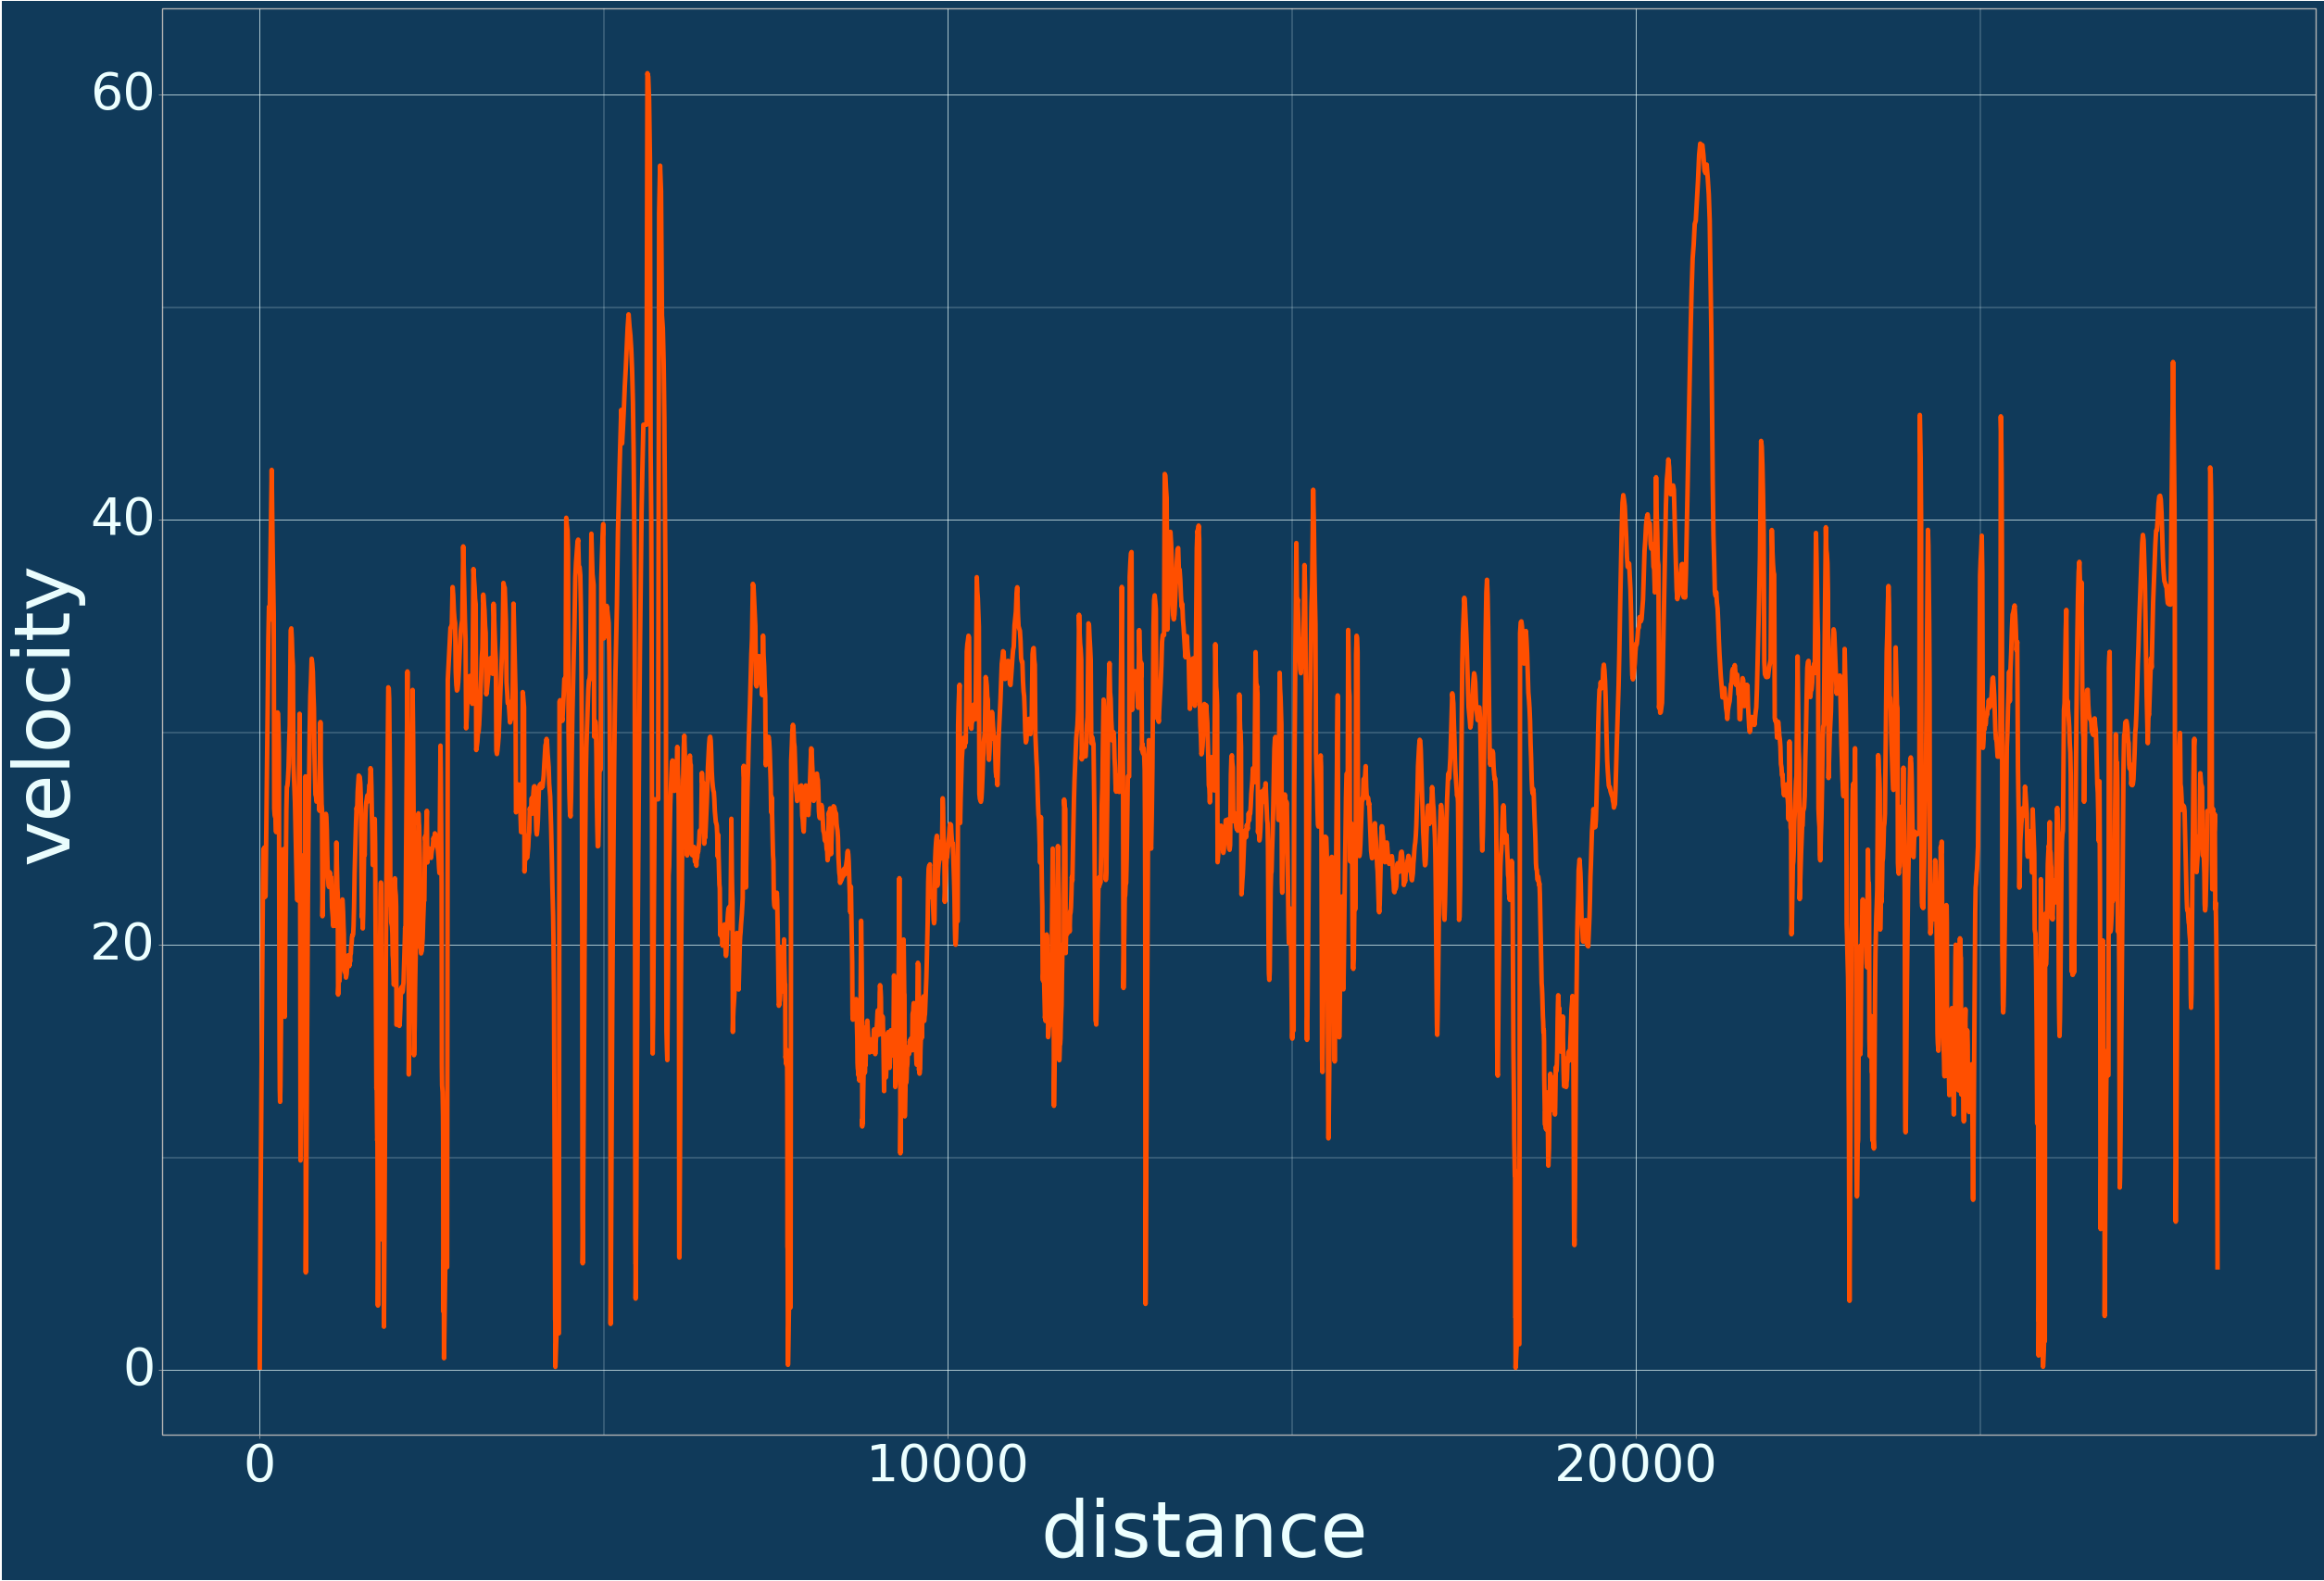

<ggplot: (276035431)>

In [6]:
pt.dark()
(gg.ggplot(stream_good, gg.aes(x='distance', y='velocity')) 
    + gg.geom_line(colour='#ff4f00', size=2)
    + gg.theme(figure_size=(14, 9))
    + pt.gg_theme()
    )

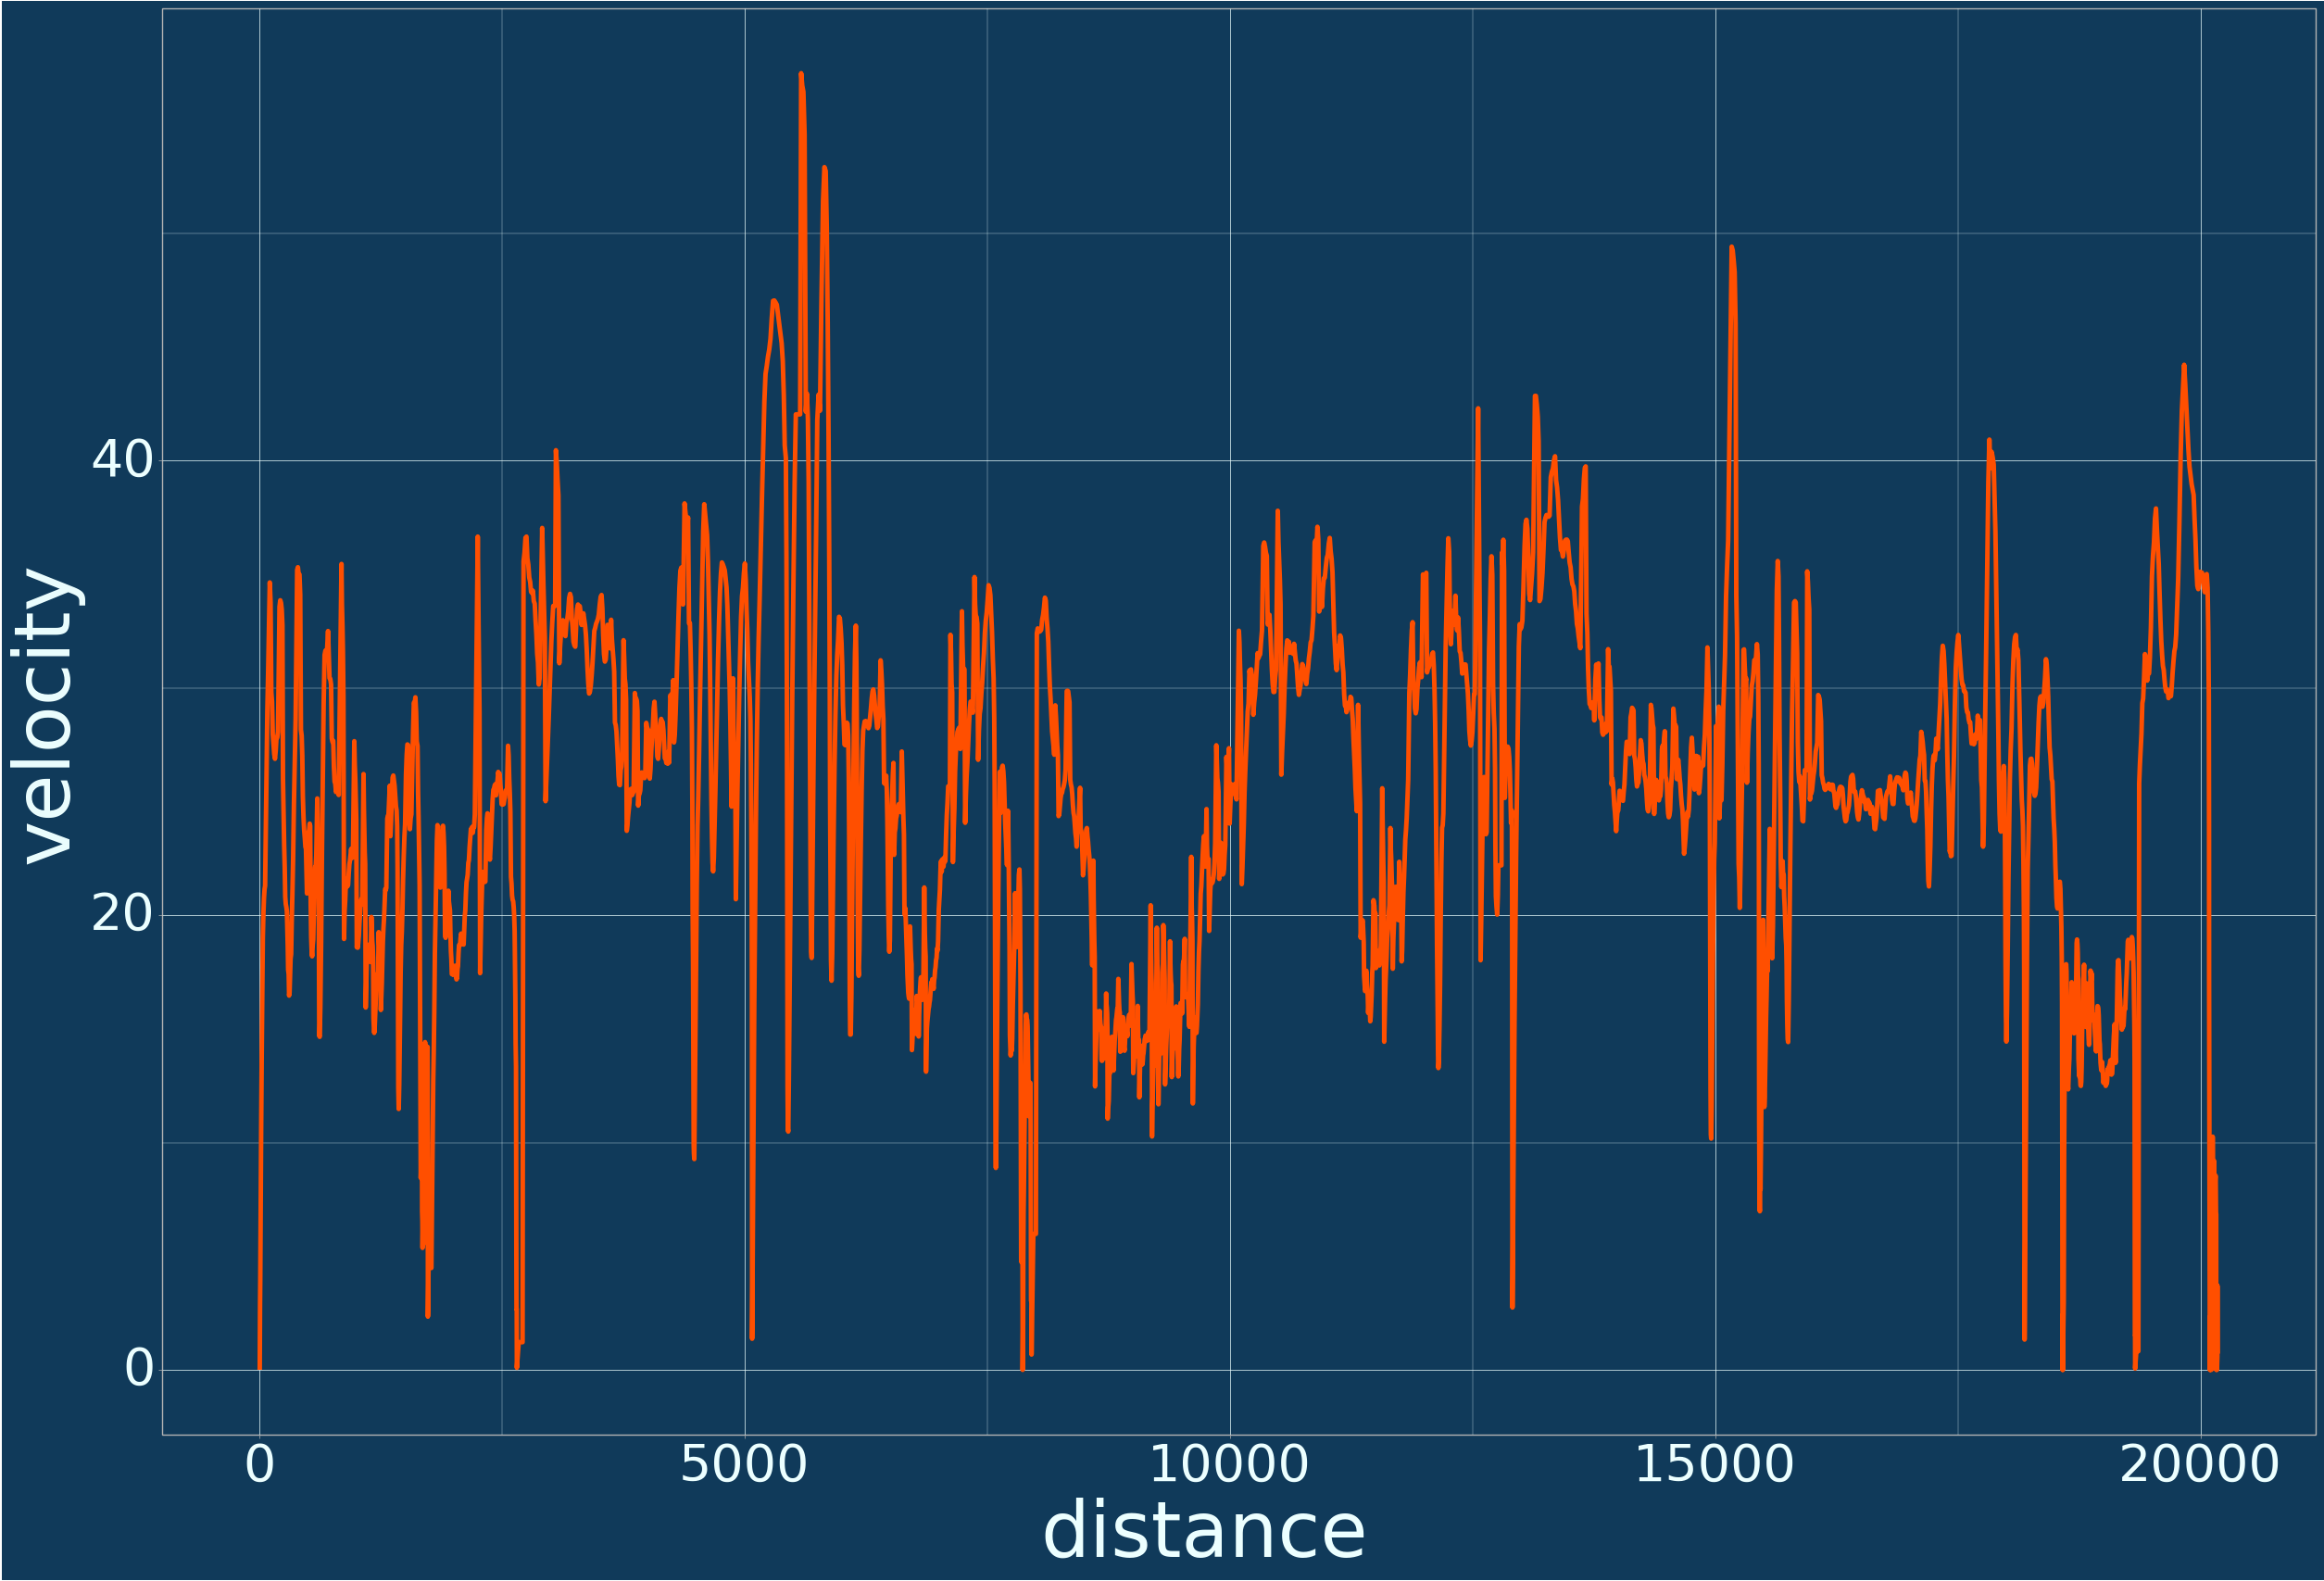

<ggplot: (828300403)>

In [7]:
pt.dark()
(gg.ggplot(stream_bad, gg.aes(x='distance', y='velocity')) 
    + gg.geom_line(colour='#ff4f00', size=2)
    + gg.theme(figure_size=(14, 9))
    + pt.gg_theme()
    )

In [8]:
stream_good['run'] = 'good'
stream_bad['run'] = 'bad'
stream = pd.concat([stream_good, stream_bad])
stream.head()

,moving,latlng,velocity,distance,altitude,heartrate,time,id,run
0,False,"[49.055074, -122.774731]",0.000,0.7,57.1,122,0,9985137901,good
1,False,"[49.055077, -122.774715]",0.000,0.7,57.0,122,1,9985137901,good
2,False,"[49.055081, -122.774707]",0.000,0.7,57.0,122,2,9985137901,good
3,True,"[49.055083, -122.774696]",1.008,1.5,57.0,122,3,9985137901,good
4,True,"[49.05509, -122.774681]",1.944,2.9,56.9,122,4,9985137901,good


/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 2944 rows containing missing values.


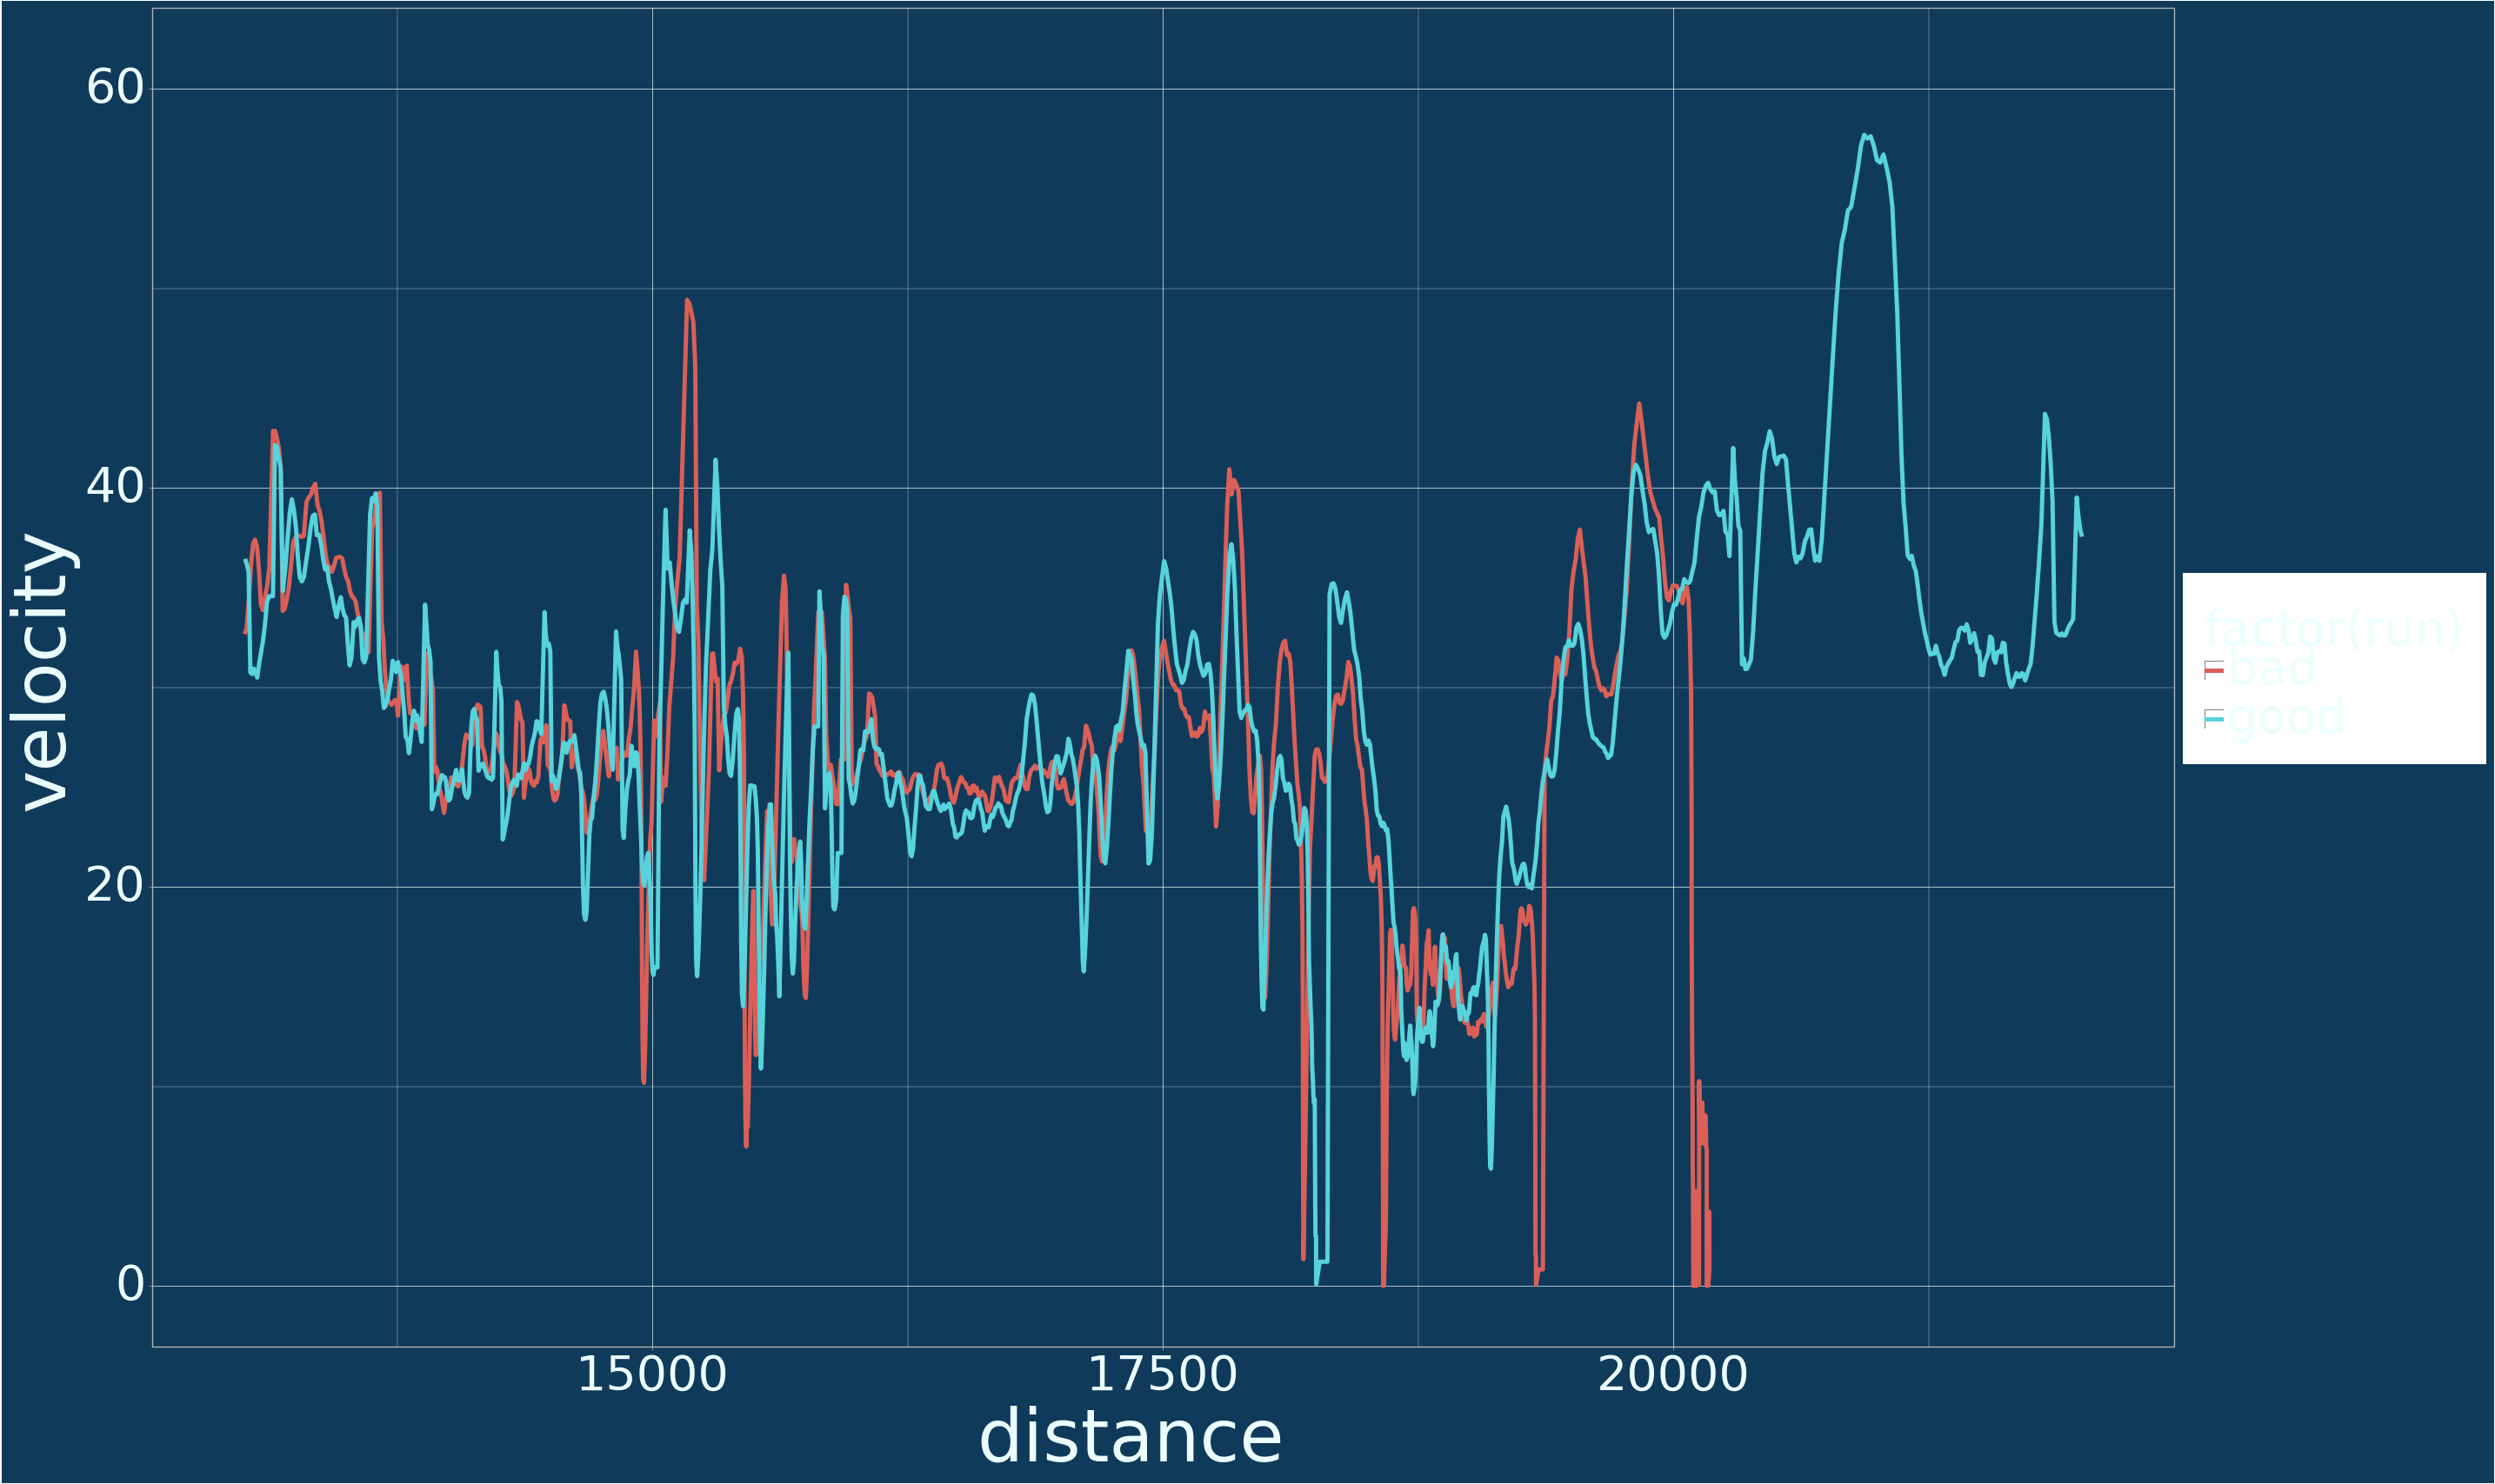

<ggplot: (830955229)>

In [9]:
pt.dark()
(gg.ggplot(stream, gg.aes(x='distance', y='velocity', colour='factor(run)')) 
    + gg.geom_line(size=2)
    + gg.theme(figure_size=(14, 9))
    + gg.scale_x_continuous(limits=[13000, 22000])
    + pt.gg_theme()
    )

In [10]:
# A really cool thing would be to gather all similar efforts and see their correlation or average or something